In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import stan 

import arviz as az 

import nest_asyncio
nest_asyncio.apply()

In [2]:
DISPLAY_X, DISPLAY_Y = 2560, 1080

In [3]:
# Read in the data
dataset = pd.read_csv("../data/full_data.csv", delimiter=";")

In [5]:
# We care about Lap 0 only
lap_0 = dataset[dataset['Lap_Number'] == 0]

Dataset:

* Timestamp
* Lap_Number (0,1)
* Position.x., Position.y., Position.z.
* Orientation.y. (0-360, yaw rotation)
* Gaze_Location.x., .y., .z. (original 3D gaze point)
* Subject
* Gaze.x. (0-2560, screen-relative gaze coord)
* Gaze.y. (0-1080, screen-relative gaze coord)
* d_ang (change in Orientation.y.)
* ang_accel (change in d_ang)
* Gate_N (Upcoming gate #, can substitute for gaze point)
* Gate_Ang (Gate orientation in world coordinates)
* Ang_Pos (0:360, angle between Orientation.y. and normal vector of upcoming gate)

In [6]:
lap_0.head(5)

,Timestamp,Lap_Number,Position.x.,Position.z.,Orientation.y.,Gaze_Location.x.,Gaze_Location.y.,Gaze_Location.z.,Subject,Gaze.x.,Gaze.y.,d_ang,ang_accel,Gate_N,Gate.x.,Gate.z.,Ang_Pos
0,1688764397682,0,-255.4,-181.8494,-3.000000e-08,-270.743971,351.035293,-138.685157,1,1157.282,434.3420,-1.764706e-07,2.209487e-06,1,-261.2452,-135.0596,0.654205
1,1688764397699,0,-255.4,-181.7235,0.000000e+00,-270.748529,351.077679,-138.680800,1,1157.288,434.6814,-1.764706e-07,3.604383e-09,1,-261.2452,-135.0596,0.659015
2,1688764397715,0,-255.4,-181.5985,0.000000e+00,-270.753086,351.120064,-138.676443,1,1157.295,435.0208,-9.803922e-09,3.604383e-09,1,-261.2452,-135.0596,0.652319
3,1688764397732,0,-255.4,-181.4766,0.000000e+00,-270.460614,351.141679,-138.868614,1,1159.131,435.3366,-9.803922e-09,-1.099337e-06,1,-261.2452,-135.0596,0.634254
4,1688764397748,0,-255.4,-181.3582,0.000000e+00,-270.292557,351.172114,-138.796529,1,1160.693,435.5298,-9.803922e-09,-6.127451e-08,1,-261.2452,-135.0596,0.614264


In [8]:
## Get rid of data with extreme values
lap_0 = lap_0[
    (lap_0['Gaze.x.'] != 0) & 
    (lap_0['Gaze.x.'] != DISPLAY_X) & 
    (lap_0['Gaze.y.'] != 0) & 
    (lap_0['Gaze.y.'] != DISPLAY_Y)
]

lap_0.shape

(98910, 17)

In [40]:
# Train-test split
train_set = lap_0[lap_0['Subject'] <= 10]
train_set.shape
train_subset = train_set[0::32]
train_subset.shape

(2082, 17)

In [41]:
## Normalizing the data
gaze_x = train_subset['Gaze.x.'] / DISPLAY_X - 0.5
gaze_y = train_subset['Gaze.y.'] / DISPLAY_Y - 0.5

<Axes: xlabel='Gaze.x.', ylabel='Gaze.y.'>

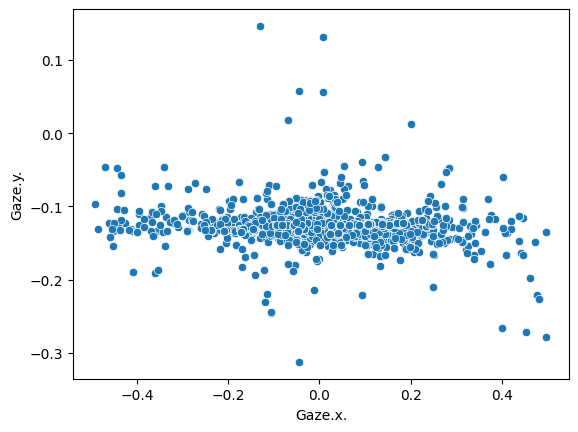

In [42]:
sns.scatterplot(x=gaze_x, y=gaze_y)

<Axes: xlabel='Gaze.x.', ylabel='Count'>

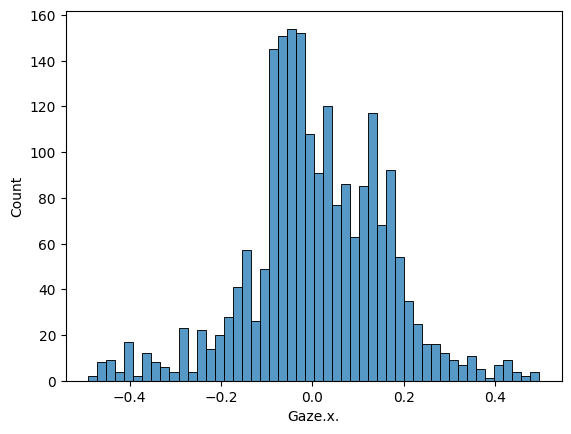

In [43]:
sns.histplot(gaze_x, bins=50)

<Axes: xlabel='Ang_Pos', ylabel='Count'>

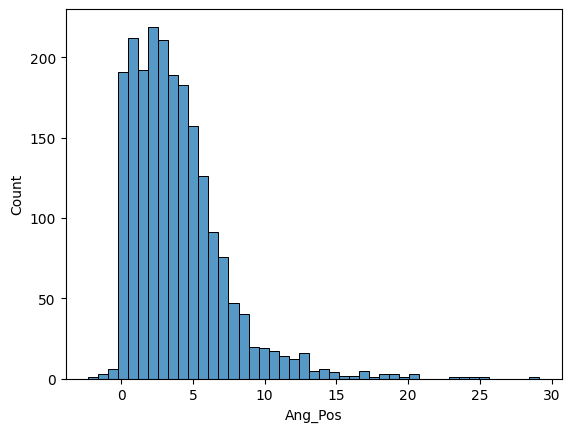

In [44]:
ang_pos = train_subset['Ang_Pos']
sns.histplot(ang_pos, bins=45)

In [45]:
train_subset['Gaze.x.'].shape == train_subset['Gaze.y.'].shape == train_subset['Ang_Pos'].shape

True

## Hierarchical Linear Regression

\begin{align}
    p_{n,j} &\sim \mathcal{N}(\beta_{0, j[n]} + \beta_{1, j[n]}x_n + \beta_{2, j[n]}y_n, \sigma).
\end{align}

In [55]:
gaze_code = """
data {
    int<lower=1> N;                     // Number of trials
    int<lower=1> J;                     // Number of subjects
    array[N] int<lower=1, upper=J> subject; // Index of subjects
    vector[N] angles;
    vector[N] x;
    // vector[N] y;
}

parameters {
    real<lower=0> sigma;    // Variance   
    real<lower=0> tau_0;
    real<lower=0> tau_x;
    // real<lower=0> tau_y;
    real beta_0;
    real beta_x;
    // real beta_y;
    vector[J] u_0;
    vector[J] u_x;
    // vector[J] u_y;
}

model {
    // Here, we construct a random-intercept, random-slope hierarchical model.

    // Level 1 Priors
    sigma ~ inv_gamma(1,1);
    tau_0 ~ inv_gamma(1,1);
    tau_x ~ inv_gamma(1,1);
    // tau_y ~ inv_gamma(1,1);
    beta_0 ~ normal(0, 10);
    beta_x ~ normal(0, 10);
    // beta_y ~ normal(0, 10);

    // Level 2 Prior
    u_0 ~ normal(0, tau_0);
    u_x ~ normal(0, tau_x);
    // u_y ~ normal(0, tau_y);

    // Likelihood
    for (n in 1:N) {
        // angles ~ normal(beta_0 + u_0[subject[n]] + (beta_x + u_x[subject[n]]) * x[n] + (beta_y + u_y[subject[n]]) * y[n], sigma);
        angles ~ normal(beta_0 + u_0[subject[n]] + (beta_x + u_x[subject[n]]) * x[n], sigma);
    }
}

generated quantities {
    vector[N] preds;

    for (n in 1:N) {
        // preds[n] = normal_rng(beta_0 + u_0[subject[n]] + (beta_x + u_x[subject[n]]) * x[n] + (beta_y + u_y[subject[n]]) * y[n], sigma);
        preds[n] = normal_rng(beta_0 + u_0[subject[n]] + (beta_x + u_x[subject[n]]) * x[n], sigma);
    }
}
"""

In [56]:
## Assemble stan-friendly data dictionary
data_dict = {
    'N': train_subset.shape[0],
    'J': np.unique(train_subset.Subject).shape[0],
    'subject': train_subset['Subject'].to_numpy(),
    'angles': ang_pos.to_numpy(),
    'x': gaze_x.to_numpy(),
    # 'y': gaze_y.to_numpy()
}

In [58]:
gaze_model = stan.build(program_code=gaze_code, data=data_dict)

Building...


Building: 45.8s, done.

In [59]:
gaze_fit = gaze_model.sample(num_chains=2, num_warmup=100, num_samples=500)

Sampling:   0%


Sampling:   0% (1/1200)
Sampling:   0% (2/1200)
Sampling:   8% (102/1200)
Sampling:  17% (202/1200)
Sampling:  25% (301/1200)Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe [system:32]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/home/geraldwong/.local/lib/python3.10/site-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: write: Broken pipe [system:32]
"""

The above exception was the direct cause of the following exception:

RuntimeError: write: Broken pipe [system:32]


AttributeError: 'NoneType' object has no attribute 'shape'

Dataset is too big. Needs some reduction.

In [26]:
summary = az.summary(gaze_fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,3.561,0.001,3.559,3.562,0.000,0.000,1136.0,699.0,1.01
tau,0.001,0.001,0.000,0.002,0.000,0.000,8.0,24.0,1.18
beta_0,4.032,0.003,4.027,4.038,0.000,0.000,137.0,187.0,1.01
beta_x,0.001,0.007,-0.014,0.013,0.001,0.000,148.0,136.0,1.01
beta_y,-0.001,0.030,-0.064,0.050,0.003,0.002,118.0,154.0,1.01
...,...,...,...,...,...,...,...,...,...
preds[3039],4.042,3.387,-1.996,10.623,0.101,0.075,1125.0,979.0,1.00
preds[3040],4.006,3.530,-2.616,10.078,0.112,0.080,989.0,915.0,1.00
preds[3041],3.878,3.610,-2.233,11.155,0.123,0.087,869.0,801.0,1.00
preds[3042],3.951,3.498,-2.448,10.544,0.110,0.078,1015.0,988.0,1.00


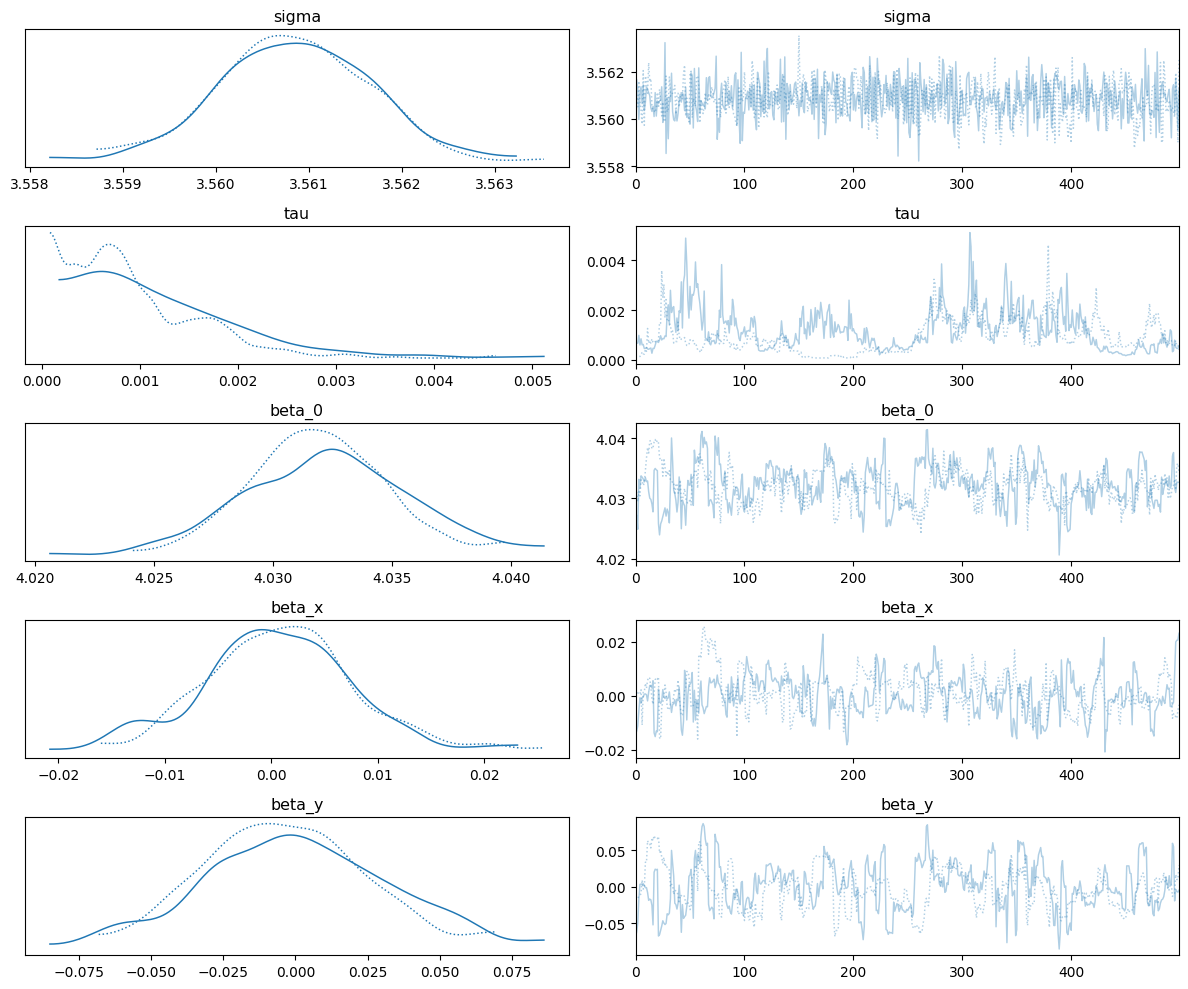

In [28]:
az.plot_trace(gaze_fit, var_names=['sigma', 'tau', 'beta_0', 'beta_x', 'beta_y'])
plt.tight_layout()